In [1]:
import os
import sys
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Iterable, Tuple, List
import tensorflow as tf
if not tf.config.list_physical_devices('GPU'):
    print('Warning: without a GPU the training will take a long time...')


In [ ]:
# Constants
IMAGE_SIZE = (256, 256, 3)
# SKETCH_ROOT = '/Users/taehun.kim/mids/rendered_256x256/256x256/sketch'
SKETCH_ROOT = r'D:\Documents\MIDS\W281\2023-mids-w81-final-project-dataset\256x256\sketch'
assert os.path.isdir(SKETCH_ROOT)

In [3]:
def get_tensorflow_dataset(ratios: List[float], augmentations: List[str] = None, seed: int = 1, batch_size: int = 32) -> List[tf.data.Dataset]:
    '''
    Get tensorflow dataset using generator to avoid RAM limitations
    Splits into train, val, test from all provided augmentations 
    '''

    # No augmentation by default
    augmentations = augmentations or ['tx_000000000000']

    assert sum(ratios) == 1 and len(ratios) == 3, 'Sum of 3 ratios must add to 1'

    datasets: List[Tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset]] = []
    for aug in augmentations:
        print(f'Reading images from augmentation {aug}...')
        train_ds = tf.keras.utils.image_dataset_from_directory(
            directory = os.path.join(SKETCH_ROOT, aug),
            image_size = IMAGE_SIZE[:2],
            label_mode='categorical',
            seed = seed,
            color_mode = 'rgb',
            validation_split = (1 - ratios[0]),
            subset = 'training',
            batch_size=batch_size
        )

        val_ds = tf.keras.utils.image_dataset_from_directory(
            directory = os.path.join(SKETCH_ROOT, aug),
            image_size = IMAGE_SIZE[:2],
            label_mode='categorical',
            seed = seed,
            color_mode = 'rgb',
            validation_split = (1 - ratios[0]),
            subset = 'validation',
            batch_size=batch_size
        )

        val_batch_count = int(tf.data.experimental.cardinality(val_ds))
        test_ds = val_ds.take(int(val_batch_count * ratios[1]))
        val_ds = val_ds.skip(int(val_batch_count * ratios[1]))

        datasets.append([train_ds, val_ds, test_ds])
    
    combined = datasets.pop()
    for train, val, test in datasets:
        combined[0] = combined[0].concatenate(train)
        combined[1] = combined[1].concatenate(val)
        combined[2] = combined[2].concatenate(test)

    return combined

In [4]:
train_ds, val_ds, test_ds = get_tensorflow_dataset([0.8, 0.1, 0.1], augmentations=['tx_000000000000'])

Reading images from augmentation tx_000000000000...
Found 75481 files belonging to 125 classes.
Using 60385 files for training.
Found 75481 files belonging to 125 classes.
Using 15096 files for validation.


In [5]:
# Build model
pretrained_resnet = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=IMAGE_SIZE,
    pooling='avg',
    classes=NUM_CLASSES,
)
pretrained_resnet.trainable = False

tf.keras.backend.clear_session()
layer = tf.keras.layers.Dense(1024, activation='relu')(pretrained_resnet.output)
layer = tf.keras.layers.Dense(512, activation='relu')(layer)
outputs = tf.keras.layers.Dense(len(train_ds.class_names), activation='softmax')(layer)
model = tf.keras.Model(pretrained_resnet.input, outputs)

In [6]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [7]:
# Reduce training size on non-powerful machines
reduce_training_size = False
actual_train_ds = train_ds.take(tf.data.experimental.cardinality(train_ds) // 100) if reduce_training_size else train_ds

epochs = 10
history = model.fit(
  actual_train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Epoch 1/10
1888/1888 [==============================] - 277s 143ms/step - loss: 2.2668 - accuracy: 0.4217 - val_loss: 1.7361 - val_accuracy: 0.5319
Epoch 2/10
1888/1888 [==============================] - 243s 129ms/step - loss: 1.5440 - accuracy: 0.5779 - val_loss: 1.5602 - val_accuracy: 0.5764
Epoch 3/10
1888/1888 [==============================] - 239s 127ms/step - loss: 1.3153 - accuracy: 0.6340 - val_loss: 1.4245 - val_accuracy: 0.6193
Epoch 4/10
1888/1888 [==============================] - 232s 123ms/step - loss: 1.1702 - accuracy: 0.6671 - val_loss: 1.3686 - val_accuracy: 0.6355
Epoch 5/10
1888/1888 [==============================] - 232s 123ms/step - loss: 1.0532 - accuracy: 0.6975 - val_loss: 1.4448 - val_accuracy: 0.6276
Epoch 6/10
1888/1888 [==============================] - 232s 123ms/step - loss: 0.9673 - accuracy: 0.7173 - val_loss: 1.4165 - val_accuracy: 0.6429
Epoch 7/10
1888/1888 [==============================] - 232s 123ms/step - loss: 0.8823 - accuracy: 0.7398 - val_

In [8]:
def plot_results(history):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    # Retrieve the training metrics (after each train epoch) and the final test accuracy.
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    ax1.set_title('Accuracy')
    ax1.plot(train_accuracy, label='train_accuracy')
    ax1.plot(val_accuracy, label='validation accuracy')
    ax1.set_xlabel('Epochs')
    ax1.legend()

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    ax2.set_title('Loss')
    ax2.plot(train_loss, label='train loss')
    ax2.plot(val_loss, label='validation loss')
    ax2.set_xlabel('Epochs')
    ax2.legend()

    plt.show()

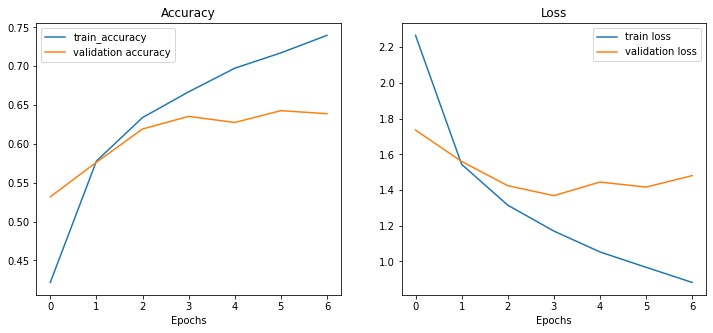

In [9]:
plot_results(history)